In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error,r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
df=pd.read_csv('train.csv')
x_test=pd.read_csv('test.csv')

In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
data_cleaner=[df,x_test]
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
#title_names = (df['Title'].value_counts() < 10)


C:\Users\user\AppData\Local\Temp\ipykernel_19260\2406982596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
C:\Users\user\AppData\Local\Temp\ipykernel_19260\2406982596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1


In [5]:
title_names=['Mr','Miss','Mrs','Master']

In [6]:

df['Title'] = df['Title'].apply(lambda x: 'Misc' if x not in title_names  else x)
x_test['Title'] = x_test['Title'].apply(lambda x: 'Misc' if x not in title_names else x)

In [7]:
set(df['Title'])

{'Master', 'Misc', 'Miss', 'Mr', 'Mrs'}

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  IsAlone      891 non-null    int64  
 14  Title        891 non-null    object 
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


In [9]:


ids=x_test['PassengerId']

df=df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
x_test=x_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())

x_test['Age'] = x_test['Age'].fillna(x_test['Age'].median())
x_test['Fare'] = x_test['Fare'].fillna(x_test['Fare'].mean())

categorical_cols = df.select_dtypes(include=['object']).columns


df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols,dtype=int)
x_test = pd.get_dummies(x_test, columns=categorical_cols, prefix=categorical_cols,dtype=int)


y_train=df['Survived']
df=df.drop(['Survived'],axis=1)

x_train, x_cv, y_train, y_cv = train_test_split(df, y_train,test_size=0.20,random_state=32)


In [10]:
'''
y_train=y_train.to_numpy()
y_train.reshape(-1,1)'''

'\ny_train=y_train.to_numpy()\ny_train.reshape(-1,1)'

In [11]:
x_test.keys()

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')

In [12]:
df.keys()

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')

In [20]:
model=Sequential([
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)
# Specify early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=500, batch_size=32,
                    validation_data=(x_cv, y_cv), callbacks=[early_stopping])

Epoch 1/500
23/23 [==============================] - 1s 8ms/step - loss: 5.2240 - accuracy: 0.5449 - val_loss: 1.3702 - val_accuracy: 0.6201
Epoch 2/500
23/23 [==============================] - 0s 3ms/step - loss: 3.8182 - accuracy: 0.5393 - val_loss: 1.2937 - val_accuracy: 0.6927
Epoch 3/500
23/23 [==============================] - 0s 3ms/step - loss: 3.7867 - accuracy: 0.5997 - val_loss: 1.1536 - val_accuracy: 0.7039
Epoch 4/500
23/23 [==============================] - 0s 3ms/step - loss: 2.8287 - accuracy: 0.5997 - val_loss: 1.0170 - val_accuracy: 0.6927
Epoch 5/500
23/23 [==============================] - 0s 3ms/step - loss: 1.9966 - accuracy: 0.6053 - val_loss: 0.9835 - val_accuracy: 0.6816
Epoch 6/500
23/23 [==============================] - 0s 3ms/step - loss: 2.0025 - accuracy: 0.5969 - val_loss: 0.9528 - val_accuracy: 0.6816
Epoch 7/500
23/23 [==============================] - 0s 3ms/step - loss: 1.4447 - accuracy: 0.6278 - val_loss: 0.8076 - val_accuracy: 0.6816
Epoch 8/500
2

In [22]:
# Get the best weights from the model
best_weights = model.get_weights()

# Reset the model to its initial weights
model.reset_states()

# Set the best weights to the model
model.set_weights(best_weights)

In [23]:
print(model.evaluate(x_cv,y_cv))
print(model.evaluate(x_train,y_train))

6/6 [==============================] - 0s 1ms/step - loss: 0.4480 - accuracy: 0.8101
[0.4479576349258423, 0.8100558519363403]
23/23 [==============================] - 0s 1ms/step - loss: 0.3935 - accuracy: 0.8385
[0.3934500217437744, 0.8384831547737122]


23/23 [==============================] - 0s 999us/step


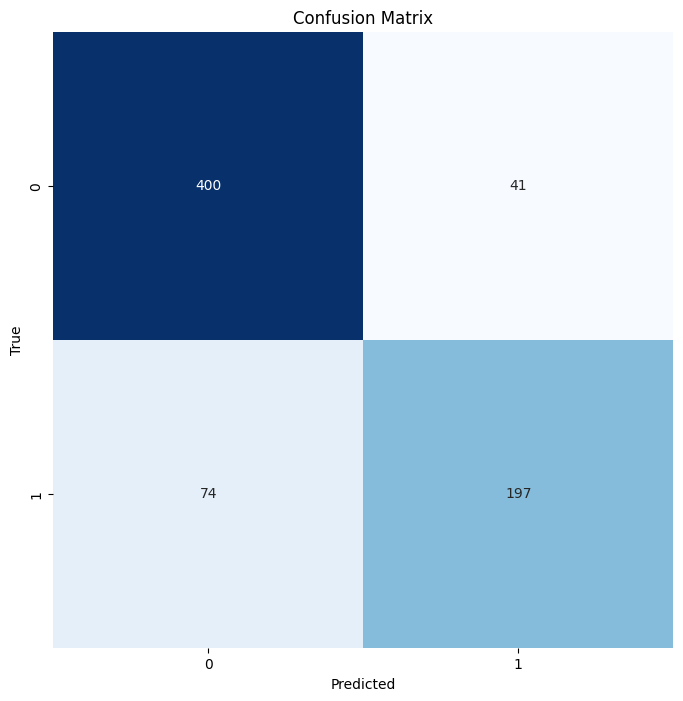

In [24]:
predictions = model.predict(x_train)
for i in range(len(predictions)):
    if predictions[i]>0.5:
        predictions[i]=1
    else:
        predictions[i]=0
        
import seaborn as sns







# Compute confusion matrix
cm = confusion_matrix(y_train, predictions)

# Plot confusion matrix using seaborn
class_names = [str(i) for i in range(2)]  
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

6/6 [==============================] - 0s 1ms/step


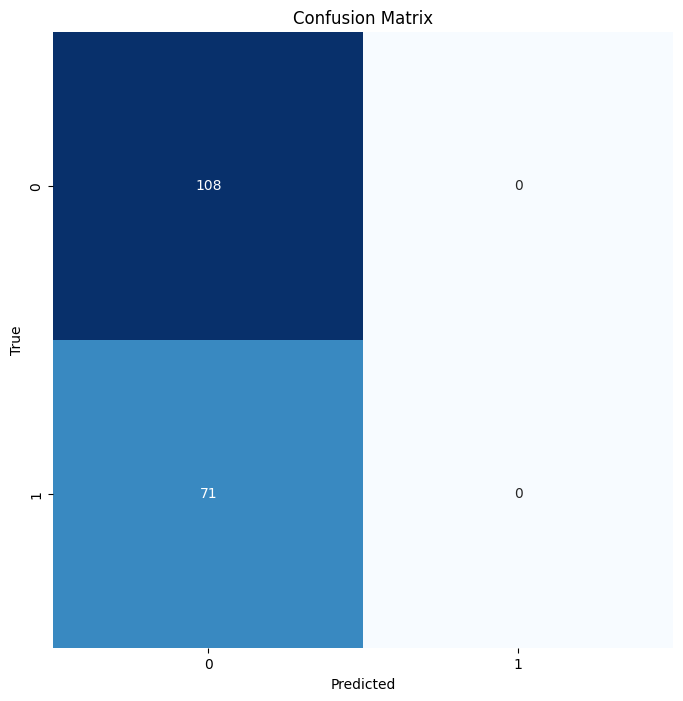

In [ ]:
import seaborn as sns



# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

true_labels = np.random.randint(0, 10, size=len(predicted_classes))

# Compute confusion matrix
cm = confusion_matrix(y_cv, predicted_classes)

# Plot confusion matrix using seaborn
class_names = [str(i) for i in range(2)]  
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_pred[i]>0.5:
        y_pred[i]=1
    else:
        y_pred[i]=0
        
y_pred=y_pred.ravel()
y_pred=y_pred.astype(int)    
print(y_pred)

ValueError: in user code:

    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 29, but received input with shape (None, 21)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 21), dtype=float64)
      • training=False
      • mask=None


In [ ]:

ids=list(ids)
submit=pd.DataFrame({'PassengerId':ids,'Survived':y_pred})
print(submit)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [ ]:
#submit.to_csv('submit4.csv',index=False)

In [ ]:
#model.save('mod.h5')

In [ ]:
plt.figure(figsize=[4,3])
plt.hist(x = [df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

KeyError: 'Survived'

<Figure size 400x300 with 0 Axes>